In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [2]:
df=pd.read_csv("weather.csv")
df.head(5)

,date,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [3]:
df.shape

(52696, 22)

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52696 entries, 0 to 52695
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  52696 non-null  object 
 1   p (mbar)              52696 non-null  float64
 2   T (degC)              52696 non-null  float64
 3   Tpot (K)              52696 non-null  float64
 4   Tdew (degC)           52696 non-null  float64
 5   rh (%)                52696 non-null  float64
 6   VPmax (mbar)          52696 non-null  float64
 7   VPact (mbar)          52696 non-null  float64
 8   VPdef (mbar)          52696 non-null  float64
 9   sh (g/kg)             52696 non-null  float64
 10  H2OC (mmol/mol)       52696 non-null  float64
 11  rho (g/m**3)          52696 non-null  float64
 12  wv (m/s)              52696 non-null  float64
 13  max. wv (m/s)         52696 non-null  float64
 14  wd (deg)              52696 non-null  float64
 15  rain (mm)          

In [5]:
df.isnull().sum()

date                    0
p (mbar)                0
T (degC)                0
Tpot (K)                0
Tdew (degC)             0
rh (%)                  0
VPmax (mbar)            0
VPact (mbar)            0
VPdef (mbar)            0
sh (g/kg)               0
H2OC (mmol/mol)         0
rho (g/m**3)            0
wv (m/s)                0
max. wv (m/s)           0
wd (deg)                0
rain (mm)               0
raining (s)             0
SWDR (W/m�)             0
PAR (�mol/m�/s)         0
max. PAR (�mol/m�/s)    0
Tlog (degC)             0
OT                      0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(1)

In [7]:
df=df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [8]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).sum()
print("Outliers in each column:")
print(outliers)

Outliers in each column:
p (mbar)                1322
T (degC)                  52
Tpot (K)                  46
Tdew (degC)                9
rh (%)                     0
VPmax (mbar)            1341
VPact (mbar)             807
VPdef (mbar)            3877
sh (g/kg)                821
H2OC (mmol/mol)          798
rho (g/m**3)              20
wv (m/s)                2021
max. wv (m/s)           1618
wd (deg)                1271
rain (mm)               1911
raining (s)             3380
SWDR (W/m�)             5714
PAR (�mol/m�/s)         5533
max. PAR (�mol/m�/s)    6022
Tlog (degC)              168
OT                      1826
dtype: int64


In [9]:
cols_to_cap = df[num_cols]

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col} - {len(outliers_after)} ")

p (mbar) - 0 
T (degC) - 0 
Tpot (K) - 0 
Tdew (degC) - 0 
rh (%) - 0 
VPmax (mbar) - 0 
VPact (mbar) - 0 
VPdef (mbar) - 0 
sh (g/kg) - 0 
H2OC (mmol/mol) - 0 
rho (g/m**3) - 0 
wv (m/s) - 0 
max. wv (m/s) - 0 
wd (deg) - 0 
rain (mm) - 0 
raining (s) - 0 
SWDR (W/m�) - 0 
PAR (�mol/m�/s) - 0 
max. PAR (�mol/m�/s) - 0 
Tlog (degC) - 0 
OT - 0 


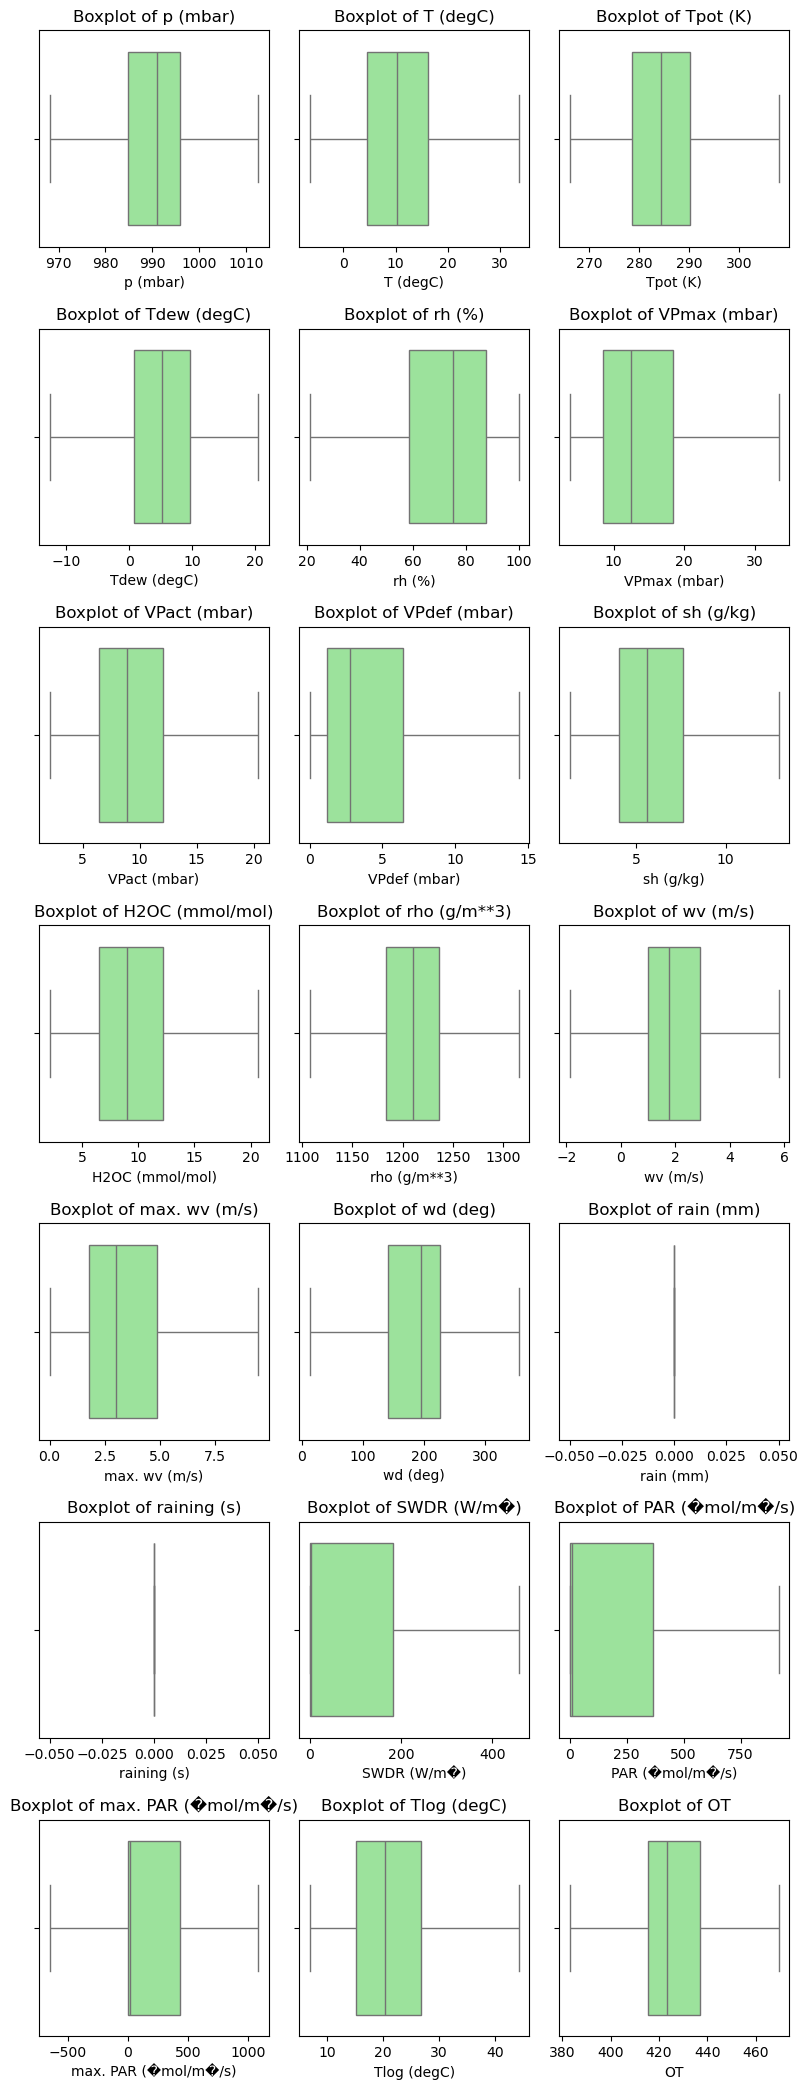

In [10]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

n_cols = len(num_cols)

rows = (n_cols + 1) // 3  
cols = 3

plt.figure(figsize=(8, 3 * rows))  

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [11]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
skew_values = df[num_cols].skew()

print("Skewness Values")
print(skew_values)

Skewness Values
p (mbar)               -0.296117
T (degC)                0.324445
Tpot (K)                0.270896
Tdew (degC)             0.037528
rh (%)                 -0.447990
VPmax (mbar)            0.927961
VPact (mbar)            0.743113
VPdef (mbar)            1.125729
sh (g/kg)               0.747883
H2OC (mmol/mol)         0.744402
rho (g/m**3)            0.066047
wv (m/s)                0.958832
max. wv (m/s)           0.931097
wd (deg)               -0.500308
rain (mm)               0.000000
raining (s)             0.000000
SWDR (W/m�)             1.251510
PAR (�mol/m�/s)         1.253851
max. PAR (�mol/m�/s)    1.243597
Tlog (degC)             0.500520
OT                      0.723600
dtype: float64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

cols_to_transform = [
    'VPmax (mbar)',
    'VPact (mbar)',
    'VPdef (mbar)',
    'sh (g/kg)',
    'H2OC (mmol/mol)',
    'wv (m/s)',
    'max. wv (m/s)',
    'SWDR (W/m�)',
    'PAR (�mol/m�/s)',
    'max. PAR (�mol/m�/s)',
    'Tlog (degC)',
    'OT'
]

pt = PowerTransformer(method='yeo-johnson')

df[cols_to_transform] = pt.fit_transform(df[cols_to_transform])

print("Yeo–Johnson Transformation Applied Successfully")
print(f"Transformed columns: {cols_to_transform}")
skew_values = df[cols_to_transform].skew()

print("Skewness Values")
print(skew_values)

Yeo–Johnson Transformation Applied Successfully
Transformed columns: ['VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'wv (m/s)', 'max. wv (m/s)', 'SWDR (W/m�)', 'PAR (�mol/m�/s)', 'max. PAR (�mol/m�/s)', 'Tlog (degC)', 'OT']
Skewness Values
VPmax (mbar)            0.026699
VPact (mbar)            0.000587
VPdef (mbar)            0.013686
sh (g/kg)               0.004204
H2OC (mmol/mol)         0.000033
wv (m/s)               -0.002440
max. wv (m/s)           0.011889
SWDR (W/m�)             0.178561
PAR (�mol/m�/s)         0.123302
max. PAR (�mol/m�/s)   -4.300692
Tlog (degC)            -0.018119
OT                      0.000000
dtype: float64


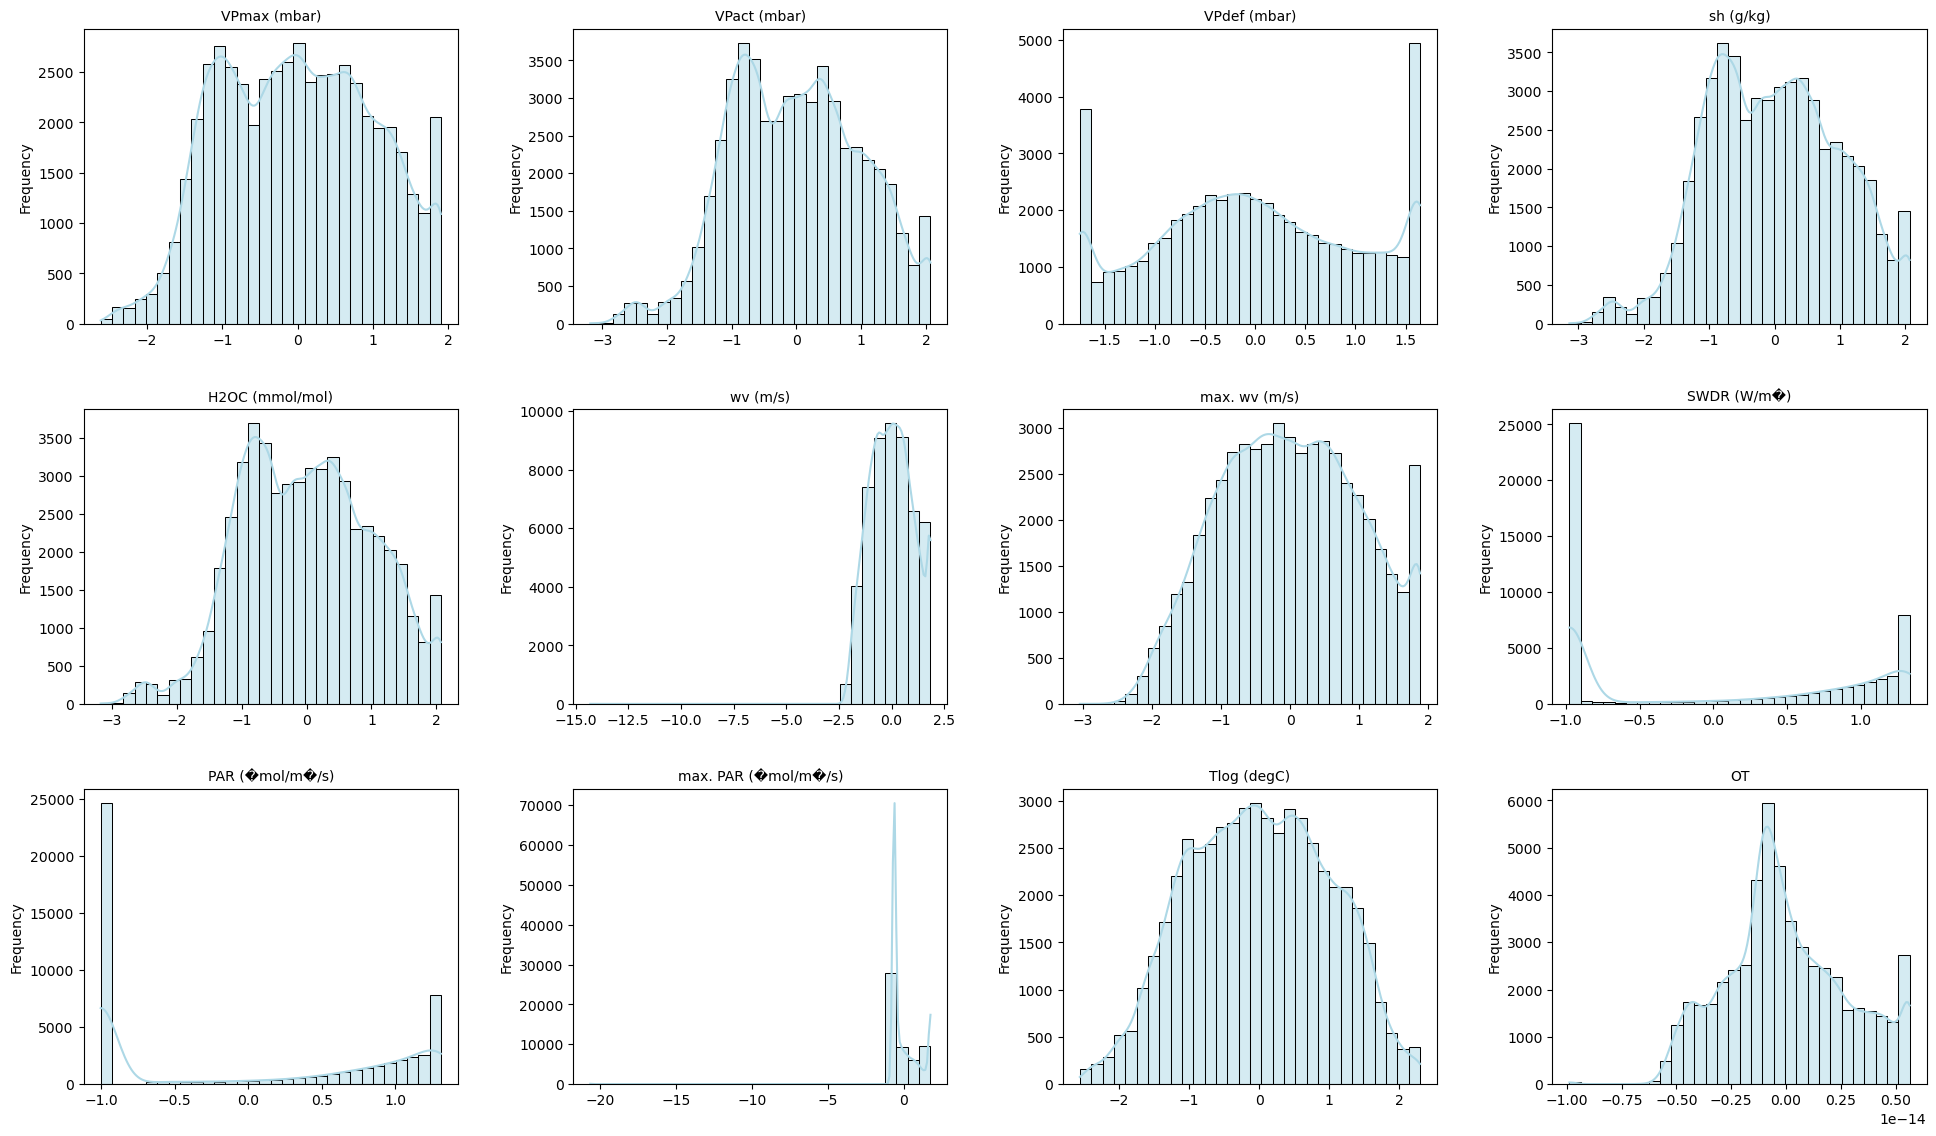

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

cols_per_row = 4
num_cols = len(cols_to_transform)
num_rows = (num_cols + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(20, num_rows * 4))  

for i, col in enumerate(cols_to_transform, 1):
    plt.subplot(num_rows, cols_per_row, i)
    sns.histplot(df[col], bins=30, kde=True, color='lightblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.xlabel('')
    plt.ylabel('Frequency')

plt.tight_layout(pad=3.0)
plt.show()


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib
import matplotlib.pyplot as plt

target_col = 'T (degC)'  # correct column name from dataset
features = df.columns.drop(['date', target_col])  

X = df[features].values
y = df[target_col].values.reshape(-1, 1)


# ---------------- 2. STANDARDIZE DATA ----------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# ---------------- 3. CREATE SEQUENCES ----------------
lookback = 36           # past 6 hours (36 × 10min)
forecast_horizon = 6    # predict 1 hour ahead

X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled) - forecast_horizon):
    X_seq.append(X_scaled[i - lookback:i])
    y_seq.append(y_scaled[i + forecast_horizon])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# ---------------- 4. TRAIN-TEST SPLIT ----------------
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# ---------------- 5. BUILD LSTM MODEL ----------------
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, X_seq.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


# ---------------- 6. CALLBACKS (Save best model automatically) ----------------
checkpoint = ModelCheckpoint(
    "lstm_model.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1
)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ---------------- 7. TRAIN MODEL ----------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

c:\Users\NANDHANAA M\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
658/659 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0750 - mae: 0.1780
Epoch 1: val_loss improved from None to 0.01657, saving model to lstm_model.keras
659/659 ━━━━━━━━━━━━━━━━━━━━ 47s 65ms/step - loss: 0.0355 - mae: 0.1330 - val_loss: 0.0166 - val_mae: 0.1014
Epoch 2/20
658/659 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0204 - mae: 0.1068
Epoch 2: val_loss improved from 0.01657 to 0.01648, saving model to lstm_model.keras
659/659 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - loss: 0.0196 - mae: 0.1046 - val_loss: 0.0165 - val_mae: 0.1035
Epoch 3/20
658/659 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0178 - mae: 0.0994
Epoch 3: val_loss improved from 0.01648 to 0.01103, saving model to lstm_model.keras
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - loss: 0.0172 - mae: 0.0978 - val_loss: 0.0110 - val_mae: 0.0811
Epoch 4/20
658/659 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0162 - mae: 0.0949
Epoch 4: val_loss did not improve from 0.01103
659/659 ━━━━━━━━━━━━━━━━━━━━ 52s 79ms/step - l

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_scaled = model.predict(X_test)

y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

# Print results
print("\n Model Evaluation Results:")
print(f" MSE  : {mse:.3f}")
print(f" RMSE : {rmse:.3f}")
print(f" MAE  : {mae:.3f}")
print(f" R²   : {r2:.3f}")

330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step

 Model Evaluation Results:
 MSE  : 0.615
 RMSE : 0.784
 MAE  : 0.605
 R²   : 0.975


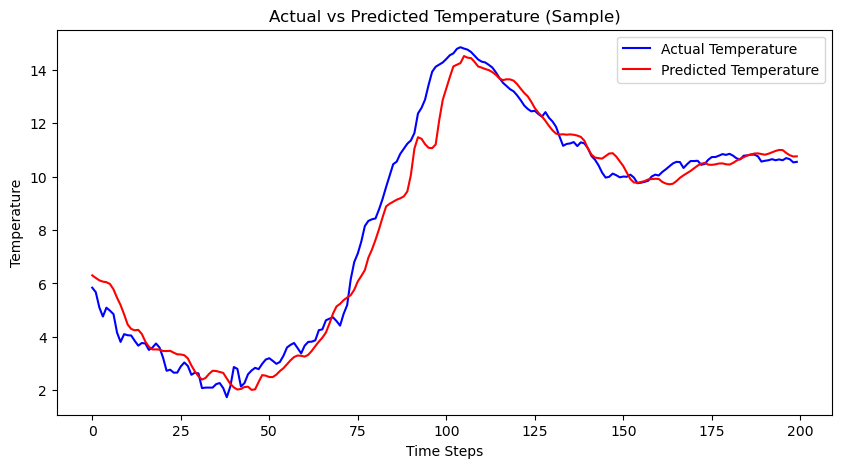

In [25]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv[:200], label='Actual Temperature', color='blue')
plt.plot(y_pred_inv[:200], label='Predicted Temperature', color='red')
plt.title('Actual vs Predicted Temperature (Sample)')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()


In [27]:
import joblib
import json

# Save scalers and model
joblib.dump(scaler_X, 'scaler_X.joblib')
joblib.dump(scaler_y, 'scaler_y.joblib')
model.save('lstm_model.h5')

# Convert features to list and save to JSON
features = list(features)  # convert from pandas Index to normal list
with open('features.json', 'w') as f:
    json.dump(features, f)

print("✅ Model, scalers, and features saved successfully!")


✅ Model, scalers, and features saved successfully!
